## Crater Detection
A reliable crater detection algorithm (CDA) is an important problem that is still unsolved.<br>
Crater statistics (count and size distributions) are important for planetary geology. Due to a wealth of high-resolution imaging on Mars, there has been an extensive effort to catalogue all of the visible craters on the red planet. Craters in greater than 1 km in diameter on Mars have been identified and documented exhaustively by one heroic effort by a researcher named <a href='https://astrogeology.usgs.gov/search/details/Mars/Research/Craters/RobbinsCraterDatabase_20120821/zip'>Stuart Robbins</a>. Once you start looking at craters smaller than 1 km in diameter, the task of hand-labeling every crater explodes; there are exponentially more craters of that size to deal with. The need for a reliable CDA becomes glaringly obvious.<br>
The most important work on this problem of the decade was arguably <a href='https://www.lpi.usra.edu/meetings/lpsc2010/pdf/1144.pdf'><I>Automatic Detection of Sub-km Craters using Shape and Texture Information</I></a> (2010 Bandiera et al.), which uses a two-step process to address the problem. The basic steps are:
 1. Identify "crater candidates" using shape filters.
 2. Classify candidates as craters or non-craters using Adaboost.
<br>


This research shows promising results, improving on previous algorithm performance. Importantly, the method opens the problem up to more researchers as a simple classification problem. Further progress on this binary classification problem is achieved in <a href='https://arxiv.org/pdf/1601.00978.pdf'><I>Crater Detection via Convolutional Neural Networks</I></a> (2016 Cohen et al.) This group is able to improve on the binary classification problem with an F1 score close to 90% on each of the three benchmark terrains on Mars.

## Outstanding Problems (Fodder for Capstone Project)
The general idea is to apply CNNs to this problem. Here are four possible approaches:

 1. Implimentation: Reproduce researchers' results (Bandiera et al. crater candidate recomendations, 2010, and Cohen et al. binary classification via neural nets, 2016) and create an accessible model/package for astronomers to utilize
 
 2. Improve on Bandiera et al. crater candidate identification work via Neural Nets (similar to: <a href='https://www.hou.usra.edu/meetings/lpsc2018/pdf/1948.pdf'>KerasCraterCNN</a>)
 
 3. Improve on <a href='https://arxiv.org/pdf/1601.00978.pdf'>Cohen's classification work</a> (F1 above 90 - plenty of room for improvement here.)
 
 4. Address other problem: hand-labeled craters (of this size) are hard to produce because you need a planetary geologist to do the labeling (no amateurs allowed.) There has been some work and talks about using synthetic planetary terrains to train such models. A cool project would be to follow <I><a href='http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf'>The Effectiveness of Data Augmentation in Image Classification using Deep Learning</a></I>, Wang & Perez, 2017 and create a platform for synthetic planetary terrain generation. The idea here would be to use GANN's to generate crater images, imbed these images into a solid color image, blend it via Wang & Perez' method with a crater-free planetary landscape of the desired resolution with a third, "crater-full" target landscape from the desired planet, long & lat, to produce massive training data for CDA.

## Potential Dataset: "The MNIST Of Crater Data"
A benchmark dataset for Mars is detailed below, a section of 6 tiles hand-labeled by an expert planetary geologist. This is the dataset used in all of the earlier mentioned papers.

In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

## The Tiles
The grid is 2 tiles tall (N to S) and three tiles wide (E to W). An overview:

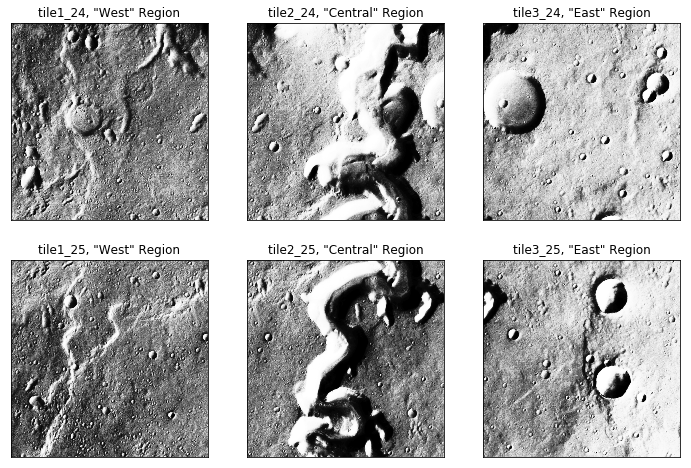

In [2]:
tile_names = [
    'tile1_24',
    'tile2_24',
    'tile3_24',
    'tile1_25',
    'tile2_25',
    'tile3_25',
]
regions = [
    '"West" Region',
    '"Central" Region',
    '"East" Region',
    '"West" Region',
    '"Central" Region',
    '"East" Region',
]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
axes = axes.reshape(6,)
for i, ax in enumerate(axes):
    ax.tick_params(
        axis='both', 
        which='both', 
        bottom='off', 
        top='off', 
        labelbottom='off', 
        right='off', 
        left='off', 
        labelleft='off'  # labels along the bottom edge are off
        )
    image_name = tile_names[i]
    ax.set_title(image_name + ', ' + regions[i])
    img = PIL.Image.open(image_name + 's.pgm')
    ax.imshow(np.array(img), cmap='Greys')

Each tile is 1700x1700 pixels, and each pixel is 12.5 square meters of the Martian surface. There is some overlap between the tiles, but each tile covers about 450 square kilometers.

## "Ground Truth" Labels
The dataset consists of 3658 craters hand-labeled (I think) by Urbach in his 2009 paper, 

In [3]:
all_craters = pd.DataFrame(columns = ['x', 'y', 'd'])
for tile in tile_names:
    num = tile[4:]
    new_craters = pd.read_csv('./gt_labels/{}_gt.csv'.format(num), header=None)
    new_craters.columns = all_craters.columns
    all_craters = pd.concat([all_craters, new_craters], axis=0)
print('{} total number of labeled craters'.format(len(all_craters)))

3658 total number of labeled craters


In [6]:
craters = pd.read_csv('./gt_labels/1_24_gt.csv', header=None)
craters.columns = ['x', 'y', 'd']

In [7]:
image_name = 'tile1_24'
img = PIL.Image.open(image_name + 's.pgm')

In [8]:
scale = .5
size = (int(img.size[0]*scale/80), int(img.size[1]*scale/80))

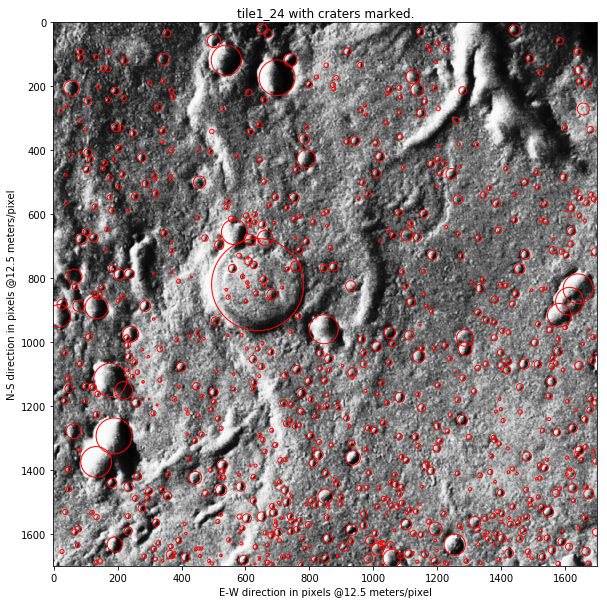

In [9]:
fig, ax = plt.subplots(figsize=size);
ax.imshow(np.array(img), cmap='Greys');
ax.set_title('{} with craters marked.'.format(image_name));
ax.set_ylabel('N-S direction in pixels @12.5 meters/pixel')
ax.set_xlabel('E-W direction in pixels @12.5 meters/pixel')
for idx in craters.index:
    crater = craters.loc[idx]
    x = crater['x']
    y = crater['y']
    r = crater['d']/2
    circle = plt.Circle((x, y), r, color='r', fill=False)
    ax.add_artist(circle)

## Crater proposals dataset
There is also a craters proposal dataset. It includes a set of proposed craters, some of which are tru and some of which are false. These proposals, and the binary classification task of rejecting false proposals, has been used as a benchmark in numerous studies.

In [10]:
true_proposals = pd.read_csv('./bandiera2010_candidates/1_24_tp.csv', header=None)
true_proposals.columns = craters.columns
false_proposals = pd.read_csv('./bandiera2010_candidates/1_24_tn.csv', header=None)
false_proposals.columns = craters.columns

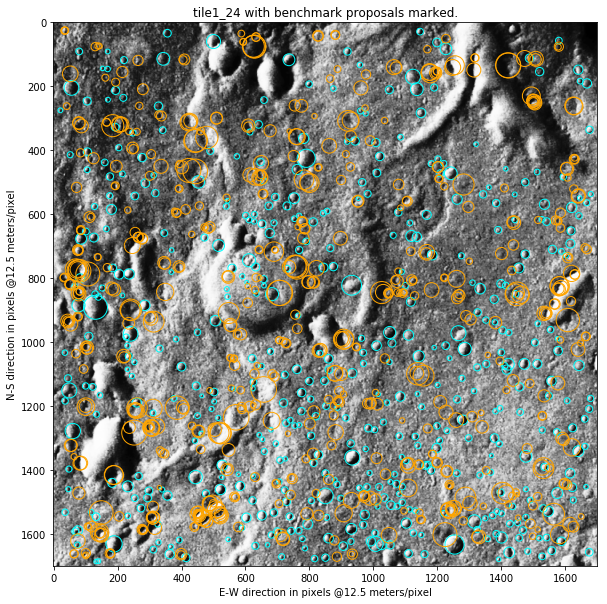

In [11]:
fig, ax = plt.subplots(figsize=size);
ax.imshow(np.array(img), cmap='Greys');
ax.set_title('{} with benchmark proposals marked.'.format(image_name));
ax.set_ylabel('N-S direction in pixels @12.5 meters/pixel')
ax.set_xlabel('E-W direction in pixels @12.5 meters/pixel')

for idx in true_proposals.index:
    crater = true_proposals.loc[idx]
    x = crater['x']
    y = crater['y']
    r = crater['d']/2
    circle = plt.Circle((x, y), r, color='cyan', fill=False)
    ax.add_artist(circle)
    
for idx in false_proposals.index:
    crater = false_proposals.loc[idx]
    x = crater['x']
    y = crater['y']
    r = crater['d']/2
    circle = plt.Circle((x, y), r, color='orange', fill=False)
    ax.add_artist(circle)